In [131]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go

In [304]:
def fetch_data(ticker, start_date='2021-01-01', end_date='2024-01-01'):
    """Fetch historical data for the given ticker."""
    return yf.download(ticker, start=start_date, end=end_date)


def ewmac(price, vol, Lfast, Lslow):
    """
    Calculate the ewmac trading rule forecast, given a price, volatility and EWMA speeds Lfast and Lslow

    Assumes that 'price' and vol is daily data

    This version uses a precalculated price volatility, and does not do capping or scaling

    :param price: The price or other series to use (assumed Tx1)
    :type price: pd.Series

    :param vol: The daily price unit volatility (NOT % vol)
    :type vol: pd.Series aligned to price

    :param Lfast: Lookback for fast in days
    :type Lfast: int

    :param Lslow: Lookback for slow in days
    :type Lslow: int

    :returns: pd.Series -- unscaled, uncapped forecast
    """
    fast_ewma = price.ewm(span=Lfast, min_periods=1).mean()
    slow_ewma = price.ewm(span=Lslow, min_periods=1).mean()
    raw_ewmac = fast_ewma - slow_ewma
    return raw_ewmac / vol.ffill()


def calculate_ewmac_signals(price, volatility, parameters):
    """
    Calculate EWMAC signals for a given price series, volatility, and a list of parameters.

    :param price: The price series
    :type price: pd.Series

    :param volatility: The volatility series
    :type volatility: pd.Series

    :param parameters: List of tuples containing fast and slow parameters
    :type parameters: list of tuples

    :returns: pd.DataFrame -- DataFrame containing EWMAC signals for each parameter pair
    """
    signals = pd.DataFrame(index=price.index)
    for i, (Lfast, Lslow) in enumerate(parameters):
        signals[f'EWMAC_{Lfast}'] = ewmac(price, volatility, Lfast, Lslow)
    return signals


def scale_cap_forecast(signals, cap=20):
    """
    Scale the forecast so it has an expected absolute average value of 10.

    :param signals: EWMAC signals.
    :return: Scaled signals.
    """
    signals = signals * 10 / signals.abs().mean()
    return signals.clip(-cap, cap)

def calculate_position_size(capped_signals, risk_target, volatility, price, capital, instrument_weights, fx_rate, idm):
    """
    Calculate the position size based on capped signals, risk target, and other parameters.

    :param capped_signals: DataFrame containing capped EWMAC signals.
    :param risk_target: Annualized risk target.
    :param volatility: Current volatility of the instrument.
    :param price: Current price of the instrument.
    :param capital: Total capital available for trading.
    :param instrument_weights: Weights of instruments in the portfolio.
    :param fx_rate: Exchange rate if applicable.
    :param IDM: Instrument Diversification Multiplier.
    :return: Position size.
    """
    multiplier = 1000
    # Calculate the average of capped signals
    average_signal = capped_signals.mean(axis=1)
    
    # Calculate risk-adjusted unrounded position
    # position = average_signal * (risk_target / volatility) * (capital * instrument_weights * fx_rate) / (price * idm)

    position = average_signal * capital * idm * instrument_weights * risk_target / (10 * multiplier * price * fx_rate * volatility)
    
    return position

def calculate_backtest_metrics(position_size, price_data, capital, strat):
    """
    Calculate various backtest metrics based on position size and price data.

    :param position_size: Series containing position size data.
    :param price_data: Series containing price data.

    :return: Dictionary containing backtest metrics.
    """
    # Join the position size and price data on their date index
    data = pd.concat([position_size, price_data], axis=1, join="inner")
    
    # Drop any rows with missing values
    data = data.dropna()

    # Calculate P&L (Profit and Loss)
    pnl = position_size * data['Close'].pct_change()
    
    # Calculate cumulative P&L
    cumulative_pnl = pnl.cumsum()

    # Calculate Sharpe ratio
    sharpe_ratio = pnl.mean() / pnl.std() * (252 ** 0.5)

    # Calculate annualized return
    annualized_return = pnl.mean() * 252

    annualized_return_pct = annualized_return*100/capital

    # Additional metrics
    drawdowns = (cumulative_pnl - cumulative_pnl.expanding().max())
    avg_drawdown = drawdowns.mean()

    # Calculate average position size
    avg_position = position_size.abs().mean()
    turnover = (position_size.diff().abs() / avg_position).sum()
    skew = pnl.skew()
    lower_tail = pnl.quantile(0.05)
    upper_tail = pnl.quantile(0.95)
    alpha = (cumulative_pnl.iloc[-1] / cumulative_pnl.std()) * (252 ** 0.5)
    
    return pd.DataFrame({
        "Initial Capital": capital,
        "Mean Annualised Return  %": annualized_return_pct,
        "Avg Drawdown %": avg_drawdown,
        "Annual Standard Deviation %": pnl.std() * (252 ** 0.5),
        "Sharpe Ratio": sharpe_ratio,
        "Turnover": turnover,
        "Skew": skew,
        "Lower Tail (5th percentile)": lower_tail,
        "Upper Tail (95th percentile)": upper_tail,
        # "Alpha": alpha,
        "Cumulative PnL": cumulative_pnl[-1]
    }, index=[strat]).T
    
def plot_position_size(position_size, price):
    """
    Plot position size against underlying price with vertical lines indicating periods of long and short positions.

    :param position_size: Position size data.
    :param price: Underlying price data.
    """
    fig = go.Figure()

    # Plot underlying price
    fig.add_trace(go.Scatter(x=price.index, y=price, mode='lines', name='Price', line=dict(color='blue')))

    # Create a separate y-axis for position size
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size, mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))

    # Add fill areas for long and short positions
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    # Add vertical lines for direction change
    for i in range(1, len(position_size)):
        if position_size[i] != 0 and position_size[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=position_size.index[i], x1=position_size.index[i], y0=0, y1=1, line=dict(color="green" if position_size[i] > 0 else "red", width=1), opacity=0.1)

    # Set layout
    fig.update_layout(title='Position Size vs Underlying Price with Direction Change Indicators', xaxis_title='Date')

    # Ensure both y-axes share y=0
    fig.update_layout(yaxis=dict(title='Price', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()

def plot_position_size_vs_pnl(position_size, price):
    """
    Plot position size against PNL with vertical lines indicating periods of long and short positions.

    :param position_size: Position size data.
    :param pnl: Profit and Loss data.
    """
    pnl = (position_size * price.pct_change()).cumsum()
    fig = go.Figure()

    # Plot PNL
    fig.add_trace(go.Scatter(x=pnl.index, y=pnl, mode='lines', name='PNL', line=dict(color='blue')))

    # Create a separate y-axis for position size
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size, mode='lines', name='Position Size', line=dict(color='red'), yaxis='y2'))

    # Add fill areas for long and short positions
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))
    fig.add_trace(go.Scatter(x=position_size.index, y=position_size * (position_size < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip', yaxis='y2'))

    # Add vertical lines for direction change
    for i in range(1, len(position_size)):
        if position_size[i] != 0 and position_size[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=position_size.index[i], x1=position_size.index[i], y0=0, y1=1, line=dict(color="green" if position_size[i] > 0 else "red", width=1), opacity=0.1)

    # Set layout
    fig.update_layout(title='Position Size vs PNL with Direction Change Indicators', xaxis_title='Date')

    # Ensure both y-axes share y=0
    fig.update_layout(yaxis=dict(title='PNL', color='blue'),
                      yaxis2=dict(title='Position Size', color='red', overlaying='y', side='right'))
    
    fig.show()

def backtest(ticker = 'BZ=F', start_date = '2021-01-01', end_date = '2024-01-01', parameters = [(8, 32), (16, 64), (32, 128), (64, 256)],
             risk_target = 0.25, capital = 100000, plot=True):
    strat = "EWMAC_"  + '_'.join([str(i[0]) for i in parameters])
    instrument_weights = 1 # Example instrument weights
    fx_rate = 1.0  # Example exchange rate if applicable
    idm = 1  # Example Instrument Diversification Multiplier

    # Fetch data
    data = fetch_data(ticker, start_date, end_date)

    # Calculate daily returns
    data['Daily_Returns'] = data['Close'].pct_change()

    # Calculate volatility
    data['Volatility'] = data['Daily_Returns'].ewm(span=30, min_periods=0).std()

    # Calculate EWMAC signals
    signals = calculate_ewmac_signals(data['Close'], data['Volatility'], parameters)

    # Scale and cap the signals
    scaled_signals = scale_cap_forecast(signals)

    # Calculate position size
    position_size = calculate_position_size(scaled_signals, risk_target, data['Volatility'], data['Close'], capital, instrument_weights, fx_rate, idm)

    backtest_metrics = calculate_backtest_metrics(position_size, data['Close'], capital, strat)
    
    # Print the calculated metrics
    print(backtest_metrics)

    if plot==True:
        plot_position_size(position_size, data['Close'])
        plot_position_size_vs_pnl(position_size, data['Close'])


    return data


<Axes: xlabel='Date'>

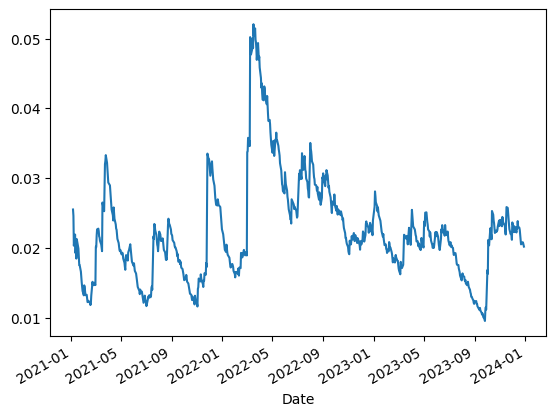

In [308]:
data["Volatility"].plot()

In [306]:
backtest()


[*********************100%***********************]  1 of 1 completed
                              EWMAC_8_16_32_64
Initial Capital                  100000.000000
Mean Annualised Return  %            42.594548
Avg Drawdown %                   -14658.550080
Annual Standard Deviation %       44403.897622
Sharpe Ratio                          0.959252
Turnover                             71.010127
Skew                                 -0.114515
Lower Tail (5th percentile)       -4783.321988
Upper Tail (95th percentile)       4932.217340
Cumulative PnL                   126769.486949


,Open,High,Low,Close,Adj Close,Volume,Daily_Returns,Volatility
Date,,,,,,,,
2021-01-04,51.660000,53.320000,50.580002,51.090000,51.090000,50232,NaN,NaN
2021-01-05,50.740002,53.880001,50.619999,53.599998,53.599998,62791,0.049129,NaN
2021-01-06,53.590000,54.720001,53.150002,54.299999,54.299999,49186,0.013060,0.025505
2021-01-07,54.139999,54.900002,53.939999,54.380001,54.380001,30800,0.001473,0.024584
2021-01-08,54.459999,56.299999,54.360001,55.990002,55.990002,37597,0.029606,0.020325
...,...,...,...,...,...,...,...,...
2023-12-22,79.440002,80.370003,78.830002,79.070000,79.070000,12334,-0.004031,0.020510
2023-12-26,79.190002,81.709999,78.809998,81.070000,81.070000,10247,0.025294,0.020819
2023-12-27,80.739998,81.320000,79.489998,79.650002,79.650002,8282,-0.017516,0.020697
